In [8]:
from IPython import display
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pretty_midi
import seaborn as sns
import tensorflow as tf

from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

# Tomb added
import random

In [9]:
#Download Chorales
data_dir = pathlib.Path('/Volumes/MAGIC1/CS50/myMusicGen/data/chorales')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'midi',
      origin='https://github.com/jamesrobertlloyd/infinite-bach/tree/master/data/chorales/midi',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )
filenames = glob.glob(str(data_dir/'**/*.mid*'))
# print(filenames)
print('Number of files:', len(filenames))

Number of files: 498


In [10]:
class UnsupportedMidiFileException(Exception):
  "Unsupported MIDI File"

In [11]:
"""Tomb made a pretty useful function"""
def check_pianoroll_dim(pianoroll):
        rows = len(pianoroll)  # This gives the number of rows
        columns = len(pianoroll[0])  # This assumes all rows have the same length

        print("Number of rows:", rows) # represents sequence length
        print("Number of columns:", columns) # represents the 4 octave range in midi 36-83
        print("Total dimesions of pianoroll is", rows*columns)

In [12]:
# seqlen = 64
# vocab_size = 128

In [19]:
def get_pianoroll(midi, nn_from, nn_thru, seqlen, tempo):
    pianoroll = midi.get_piano_roll(fs=2*tempo/60) # This is the core line which makes this matrix based on 8th note
    # print(f"piano_roll.shape[1] a.k.a song length!{pianoroll.shape[1]}")

    if pianoroll.shape[1] < seqlen:
        raise UnsupportedMidiFileException

    pianoroll = pianoroll[nn_from:nn_thru, 0:seqlen] # (48, 64) Pinoroll's value still NOT binary since it has velocity
    binary_pianoroll = np.heaviside(pianoroll, 0) # converting as a binary matrix
    transposed_pianoroll = np.transpose(binary_pianoroll) #(64, 48)
     
    # return binary_pianoroll
    return transposed_pianoroll # type numpy.ndarray

#### Read_Midi Explanation

Get Major key(keymode=0) or Minor key(keymode=1)<br>
key_number has values ​​from 0 to 11 for major keys and for minor keys,
12~23 is included, <br> so by **dividing it by 12** and converting it to an integer,<br> 

it will be 0 if it is a major key,<br>
it will be 1 if it is a minor key,<br>

and assign it accordingly to keymode.

In [14]:
# def read_midi(filename, sop_alto, seqlen):
  
#   def add_rest_nodes(pianoroll):  # If all the elemets are zero, the rest node says 1, else 0
#     rests = 1 - np.sum(pianoroll, axis=1)
#     rests = np.expand_dims(rests, 1)
#     return np.concatenate([pianoroll, rests], axis=1)
  
  
#   # read midi file
#   midi = pretty_midi.PrettyMIDI(filename)

#   # An Exception error is thrown if there is a modulation(key change)
#   if len(midi.key_signature_changes) !=1:
#     raise UnsupportedMidiFileException

#   # Modulate the given key to C major or C minor
#   key_number = midi.key_signature_changes[0].key_number
#   # transpose_to_c(midi, key_number)

#   # Get Major key(keynode=0) or Minor key(keynode=1)
#   keymode = np.array([int(key_number / 12)])

#   # The Exception error thrown when tempo changes
#   tempo_time, tempo = midi.get_tempo_changes()
#   if len(tempo) != 1:
#     raise UnsupportedMidiFileException
#   if sop_alto:
#     # The exception thrown if there are less than 2 parts
#     if len(midi.instruments) < 2:
#       raise UnsupportedMidiFileException
#     # Get pianoRoll returns numpy.ndarray
#     pr_s = get_pianoroll(midi.instruments[0], 36, 84, seqlen, tempo[0])
#     pr_a = get_pianoroll(midi.instruments[1], 36, 84, seqlen, tempo[0])
#     pr_b = get_pianoroll(midi.instruments[2], 36, 84, seqlen, tempo[0])
    
    
#     sop_w_rest = add_rest_nodes(pr_s) 
#     alt_w_rest = add_rest_nodes(pr_a)
#     bass_w_rest = add_rest_nodes(pr_b)
    
#     # return pr_s, pr_a, pr_b, keymode
#     return sop_w_rest, alt_w_rest, bass_w_rest, keymode # All numpy.ndarray including keymode  

#   else:
#     #Get a pianoroll which gathered all the parts
#     pr = get_pianoroll(midi, 36, 84, seqlen, tempo[0])
#     return pr, keymode

#   # Tomb added  
#   # pr = get_pianoroll(midi, 36, 84, seqlen, tempo[0])
#   # # pr_w_rest = add_rest_nodes(pr)
#   # # print(pr_w_rest)
#   # # return pr_w_rest, keymode
#   # return pr, keymode

In [42]:
def read_midi(filename, sop_alto, seqlen):
  
  def add_rest_nodes(pianoroll):  # If all the elemets are zero, the rest node says 1, else 0
    count_ones = np.count_nonzero(pianoroll == 1)
    count_zeros = np.count_nonzero(pianoroll == 0)
  
    #"There is only one '1' and the rest are '0's in the array."
    if count_ones == 1 and count_zeros == pianoroll.size - 1: # pinoroll size 3072
        rests = 1 - np.sum(pianoroll, axis=1)
        rests = np.expand_dims(rests, 1)
        return np.concatenate([pianoroll, rests], axis=1)
    
    #"All elements in the array are '0's."
    elif count_zeros == pianoroll.size:
        rests = 1 - np.sum(pianoroll, axis=1)
        rests = np.expand_dims(rests, 1)
        return np.concatenate([pianoroll, rests], axis=1)
    
    #"There are either multiple '1's or different values in the array."
    else:
        total_sum = np.sum(pianoroll, axis=1)
        rests = total_sum-total_sum 
        rests = np.expand_dims(rests, 1)
        return np.concatenate([pianoroll, rests], axis=1)
  
  
  # read midi file
  midi = pretty_midi.PrettyMIDI(filename)

  # An Exception error is thrown if there is a modulation(key change)
  if len(midi.key_signature_changes) !=1:
    raise UnsupportedMidiFileException

  # Modulate the given key to C major or C minor
  key_number = midi.key_signature_changes[0].key_number
  # transpose_to_c(midi, key_number)

  # Get Major key(keynode=0) or Minor key(keynode=1)
  keymode = np.array([int(key_number / 12)])

  # The Exception error thrown when tempo changes
  tempo_time, tempo = midi.get_tempo_changes()
  if len(tempo) != 1:
    raise UnsupportedMidiFileException
  if sop_alto:
    # The exception thrown if there are less than 2 parts
    if len(midi.instruments) < 2:
      raise UnsupportedMidiFileException
    # Get pianoRoll returns numpy.ndarray
    pr_s = get_pianoroll(midi.instruments[0], 36, 84, seqlen, tempo[0])
    pr_a = get_pianoroll(midi.instruments[1], 36, 84, seqlen, tempo[0])
    pr_b = get_pianoroll(midi.instruments[2], 36, 84, seqlen, tempo[0])
    wholePart = get_pianoroll(midi, 36, 84, seqlen, tempo[0])
    
    
    sop_w_rest = add_rest_nodes(pr_s) 
    alt_w_rest = add_rest_nodes(pr_a)
    bass_w_rest = add_rest_nodes(pr_b)
    wholePart_w_rest = add_rest_nodes(wholePart)
    
    # return pr_s, pr_a, pr_b, keymode
    print("whole_Part_w_rest!!",wholePart_w_rest.shape)
    return sop_w_rest, alt_w_rest, bass_w_rest, wholePart_w_rest, keymode # All numpy.ndarray including keymode  

  # else:
  #   #Get a pianoroll which gathered all the parts
  #   pr = get_pianoroll(midi, 36, 84, seqlen, tempo[0])
  #   return pr, keymode

  # Tomb added  
  # pr = get_pianoroll(midi, 36, 84, seqlen, tempo[0])
  # # pr_w_rest = add_rest_nodes(pr)
  # # print(pr_w_rest)
  # # return pr_w_rest, keymode
  # return pr, keymode

#### Make the training data

In [ ]:
"""Get the ingredients. 
Make the data(i.e manipulate the model as you tell it what you want) here for predict the 3rd note with given (x1,x2). 
Make list1 that has (xn, xn+1) pair elements 
and list2 which has (xn+2) elements"""

np.set_printoptions(threshold=np.inf) # Show the entire print, esp Matrix

x_all = [] 
y_all = [] 
keymodes = [] 
files = []

# repeat the process with all the midi files
for f in glob.glob(str(data_dir/"**/*.mid*")):
  # print(f)
  try:
    # sop, alt, bass, keymode = read_midi(f, True, 64)
    sop, alt, bass, whole_Part, keymode = read_midi(f, True, 64)
    x_all.append(sop)
    y_all.append(alt)

    # add pianorolls which have been added rest elements to the lists
    
  # throw exception for midi data which can not be used
  except UnsupportedMidiFileException:
    print("nah")
n_notes = len(x_all) # Not sure if it is correct
# print("n_notes!",n_notes)

# convert x_all and y_all into NumPy array to make them more useful later

# Tomb added. These three lines of code is for getting the number of pitch range
# The pitch range is 49 at this point as rest_node dim is added, refer to prof's docu
x_all = np.array(x_all) # shape(31680, 2)  495 * 64=31680
y_all = np.array(y_all) # shape(31680, 1)

# print(x_all.shape[2])
# pitch_range = x_all.shape[2] # not used yet

# x_all = np.array(x_all)
# y_all = np.array(y_all)

# You get an error with this  code but can see the shape
# x = pd.DataFrame(y_all)
# print(x)

# print("x_all shape",x_all.shape)
# print("y_all shape",y_all.shape)
# print(x_all[:11])
# print(y_all[:11])

### Attempt getting data 

In [ ]:
# the range method returns a sequencce of numbers(0, 495), so it satisfies the test_split parameters
i_train, i_test = train_test_split(range(len(x_all)),
                                   test_size=int(len(x_all)/2), shuffle=False)
print(range(len(x_all)))

x_train = x_all[i_train] # shape (15840, 2)
x_test = x_all[i_test] # shape (15840, 2)

y_train = y_all[i_train] # shape (15840, 1)
y_test = y_all[i_test] # shape (15840, 1)

range(0, 495)


In [ ]:
# kthr code 3.6

seq_length = x_train.shape[1] #int 2
# input_dim = x_train.shape[0] #int 2
# output_dim = y_train.shape[1] #int 1

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(
    128, input_shape=(64,49), use_bias=True,
    activation="tanh", return_sequences=True
))
model.add(tf.keras.layers.Dense(
    49, use_bias=True, activation="softmax"
))
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics="categorical_accuracy")

model.summary()

#Outputhape (None, 2, 128)  


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64, 128)           91136     
                                                                 
 dense_3 (Dense)             (None, 64, 49)            6321      
                                                                 
Total params: 97457 (380.69 KB)
Trainable params: 97457 (380.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
print(x_test.shape)
print(y_test.shape)

model.evaluate(x_test, y_test)

(247, 64, 49)
(247, 64, 49)
8/8 [==============================] - 1s 11ms/step - loss: 3.8962 - categorical_accuracy: 0.0028


[3.896193027496338, 0.0027834007050842047]

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath="./training_checkpoints/ckpt_{epoch}",
        save_weights_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="loss",
        patience=5,
        verbose=1,
        restore_best_weights=True
    )]

epochs = 250
batch_size = 32

history = model.fit(
    x_train, y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks)

Epoch 1/250
8/8 [==============================] - 1s 43ms/step - loss: 3.8231 - categorical_accuracy: 0.1427
Epoch 2/250
8/8 [==============================] - 0s 31ms/step - loss: 3.3808 - categorical_accuracy: 0.2463
Epoch 3/250
8/8 [==============================] - 0s 31ms/step - loss: 2.7983 - categorical_accuracy: 0.2413
Epoch 4/250
8/8 [==============================] - 0s 31ms/step - loss: 2.6350 - categorical_accuracy: 0.2519
Epoch 5/250
8/8 [==============================] - 0s 30ms/step - loss: 2.5544 - categorical_accuracy: 0.2591
Epoch 6/250
8/8 [==============================] - 0s 30ms/step - loss: 2.4920 - categorical_accuracy: 0.2699
Epoch 7/250
8/8 [==============================] - 0s 30ms/step - loss: 2.4370 - categorical_accuracy: 0.2730
Epoch 8/250
8/8 [==============================] - 0s 32ms/step - loss: 2.3751 - categorical_accuracy: 0.3071
Epoch 9/250
8/8 [==============================] - 0s 31ms/step - loss: 2.3333 - categorical_accuracy: 0.3177
Epoch 10/2

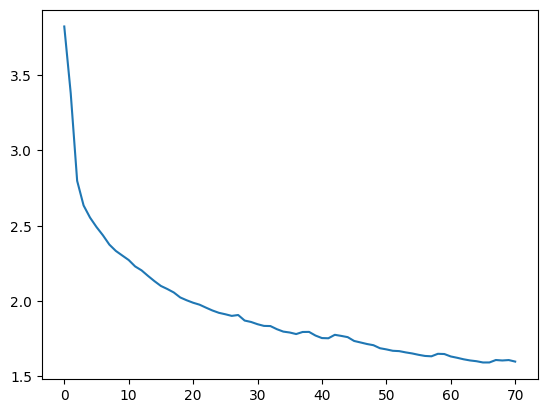

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

### Generate Notes

In [ ]:
# y_pred = model.predict(x_test) # returns numpy.ndarray

In [ ]:
def predict_next_note(
        notes: np.ndarray, # 3D
        model: tf.keras.Model,
        temperature: float = 1.0) -> tuple[int]: # -> indicates what you return
    """Generates a note, using a trained sequence model."""
    assert temperature > 0 
    # Add batch dimension
    # inputs = tf.expand_dims(notes, 0)
    # print("notes!!",notes[1,:2])
    predictions = model.predict(notes) # predictions (64, 64, 49) 
    note_logits = predictions[1] # make a 2D tensor for random.categoriacal's 1st arg by accessing the [1]. note_logits (64, 49)
    # print("note_logits!!", note_logits[1:2])
    note_logits /= temperature
    print("note_logits2!!", note_logits[1:2])
    pitch = tf.random.categorical(note_logits, num_samples=1) #random.categorical requires 2D tensor for logits
    print("categorical pitch!!", pitch)
    pitch = tf.squeeze(pitch, axis=-1)
    # print(f"pitch after squeezed{pitch}")
    
    # print("pitch!!",pitch)
    return pitch # shape (64,)

In [ ]:
temperature = 2.0

input_notes = y_test[: seq_length] # 3D. 0-64 songs in the input notes and NOT the ideal shape
# print("y_test shape!!",y_test.shape)
# print("input_notes!!\n",input_notes[1,:2])

generated_notes = predict_next_note(input_notes, model, temperature)

generated_notes = pd.DataFrame(
    generated_notes
)
generated_notes.columns = ["pitch"] # Give the label to the column to access it
# generated_notes.head(10)

2/2 [==============================] - 0s 10ms/step
note_logits2!! [[7.7992685e-05 1.7906226e-04 1.5984406e-04 2.2523532e-04 1.0853076e-04
  2.0086484e-04 1.6791676e-04 6.4211039e-05 6.3443229e-05 1.6670619e-04
  2.3880287e-04 4.2489645e-04 3.2211802e-04 6.0544826e-05 2.7182428e-04
  9.2527851e-05 7.5507723e-04 5.9206720e-04 1.4312936e-04 4.6648658e-04
  4.5896781e-04 9.7252952e-04 1.0243692e-03 1.5727618e-03 1.8312514e-03
  1.4098409e-03 2.6392587e-03 2.1972263e-03 3.0215045e-03 2.0590315e-03
  2.1725276e-03 1.6497154e-03 1.9311263e-03 2.2576156e-03 1.5687795e-03
  8.9002558e-04 6.8167323e-04 2.6083548e-04 9.9949562e-04 5.4834870e-04
  5.7505153e-04 3.6268239e-04 4.6105779e-04 5.3557323e-04 2.0579615e-04
  8.7896675e-05 3.2624236e-04 2.6569961e-04 4.6225184e-01]]
categorical pitch!! tf.Tensor(
[[ 7]
 [21]
 [46]
 [ 8]
 [32]
 [23]
 [44]
 [ 5]
 [16]
 [21]
 [46]
 [ 7]
 [29]
 [37]
 [25]
 [ 3]
 [33]
 [38]
 [36]
 [17]
 [ 2]
 [ 4]
 [47]
 [21]
 [19]
 [ 2]
 [ 2]
 [22]
 [ 0]
 [13]
 [ 9]
 [11]
 [

In [ ]:
_SAMPLING_RATE = 16000
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=40):
    waveform = pm.fluidsynth(fs=float(_SAMPLING_RATE))
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    print(waveform_short[:9])
    return display.Audio(waveform_short, rate=_SAMPLING_RATE) # this display class is from IPython

In [ ]:
def pandas_to_midi(notes:pd.DataFrame):
    data = notes["pitch"]
    df = pd.DataFrame(data)

    # Convert pitch values to MIDI notes
    notes = df['pitch'].tolist()
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)

    # Add notes to the MIDI object
    for i, note in enumerate(notes):
        note_start = i * 0.5  # Adjust the start time as needed
        note_end = note_start + 0.4  # Adjust the end time as needed. Make + 1.4 you can hear pedal-sustain like notes
        midi_note = pretty_midi.Note(velocity=100, pitch=note, start=note_start, end=note_end)
        instrument.notes.append(midi_note)

    pm.instruments.append(instrument)
    
    return pm

In [ ]:
pm = pandas_to_midi(generated_notes)

# Display audio using your function
display_audio(pm)


[ 0.          0.          0.         -0.00120919  0.          0.00120919
  0.          0.          0.00120919]


### --Experimental or Unused code Below-- 

In [ ]:
"""Attempted by using tf.data.Dataset for trainig data"""
# x_ds = tf.data.Dataset.from_tensor_slices(x_all)
# y_ds = tf.data.Dataset.from_tensor_slices(y_all)
# print(x_ds.element_spec)
# for i, f in enumerate(x_ds):
#     print(i, f.numpy())

# note_ds = tf.data.Dataset.from_tensor_slices(x_all)
# note_ds.element_spec

'Attempted by using tf.data.Dataset for trainig data'

In [ ]:
# seq_ds = create_sequences(note_ds, seqlen, vocab_size) # Vocab size is not used yet as I do not know how to handle normlization with this data

# print(seq_ds.element_spec)


In [ ]:
# elm = 2
# for seq in x_seq_ds.take(1):

#   print('sequence shape:', seq.shape)
#   print(f'sequence elements (first {elm}):', seq[0: elm]) 

In [ ]:
# batch_size = 64
# buffer_size = n_notes - seqlen

# train_ds = (seq_ds
#             .shuffle(buffer_size)
#             # .batch(batch_size, drop_remainder=True)
#             .cache()
#             .prefetch(tf.data.experimental.AUTOTUNE)
#             )

# print(train_ds.element_spec) # (batch_size, seqlen, pitch_range)

In [ ]:
# input_shape = (seqlen, pitch_range) # (64, 49)
# learning_rate = 0.005

# inputs = tf.keras.Input(input_shape)
# x = tf.keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True)(inputs)
# outputs = tf.keras.layers.Dense(1)(x)

# model = tf.keras.Model(inputs, outputs)

# loss = tf.keras.losses.CategoricalCrossentropy(
#         from_logits=True) # To set True automatically adds softmax

# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# metrics = tf.keras.metrics.CategoricalCrossentropy()

# model.compile(loss=loss,
#               optimizer=optimizer,
#               metrics=[metrics])
# model.summary()


In [ ]:
# losses = model.evaluate(train_ds, return_dict=True)
# losses

In [ ]:
# def notes_to_midi(
#   notes: pd.DataFrame,
#   out_file: str, 
#   instrument_name: str,
#   velocity: int = 100,  # note loudness
# ) -> pretty_midi.PrettyMIDI:

#   pm = pretty_midi.PrettyMIDI()
#   instrument = pretty_midi.Instrument(
#       program=pretty_midi.instrument_name_to_program(
#           instrument_name))

#   prev_start = 0
  
#   for i, note in notes.iterrows():
#     note = note["pitch"]
#     print("note!!", note)
#     start = float(prev_start + note)
#     end = float(start + note)
#     note = pretty_midi.Note(
#         velocity=velocity,
#         pitch=int(note),
#         start=start,
#         end=end,
#     )
#     instrument.notes.append(note)
#     prev_start = start

#   pm.instruments.append(instrument)
#   pm.write(out_file)
#   return pm

In [ ]:
"""Check the dimension of the matrix"""

# rows = len(training_data)
# columns = len(training_data[0]) if training_data else 0  # Assuming all rows have the same length

# print("Shape of the list:", rows, "x", columns, f"shape{rows, columns}")
# print("The total dimension of this matrx is:", rows*columns)

'Check the dimension of the matrix'

In [ ]:
# def read_midi(filename, sop_alto, seqlen):
#   midi = pretty_midi.PrettyMIDI(filename)

#   if len(midi.key_signature_changes) !=1: # An Exception error is thrown if there is a modulation(key change)
#     raise UnsupportedMidiFileException

#   key_number = midi.key_signature_changes[0].key_number # explained in the text
#   keymode = np.array([int(key_number / 12)])

  
#   _, tempo = midi.get_tempo_changes() # _ can be written as tempo_time but won't be used w/in this function
#   if len(tempo) != 1: # counting the number of elements in the tempo array. # The Exception error thrown when tempo changes
#     raise UnsupportedMidiFileException

#   if sop_alto: # The argument is coming in as boolean, True or False
#     if len(midi.instruments) < 2: # The exception thrown if there are less than 2 parts
#       raise UnsupportedMidiFileException

#     # Get pianoRoll binary Matrix for each of Soprano, alto, bass parts
#     pr_s = get_pianoroll(midi.instruments[0], 36, 84, seqlen, tempo[0]) # Get pianoroll's arguments (midi, nn_from, nn_thru, seqlen, tempo):
#     pr_a = get_pianoroll(midi.instruments[1], 36, 84, seqlen, tempo[0])
#     pr_b = get_pianoroll(midi.instruments[2], 36, 84, seqlen, tempo[0])

#     # return pr_s, keymode
#     return pr_s, pr_a, pr_b, keymode 
    

#   else:
#     # Get a pianoroll which gathered all the parts
#     pr = get_pianoroll(midi, 36, 84, seqlen, tempo[0])
#     return pr, keymode

In [ ]:
# def add_rest_nodes(pianoroll):  # If all the elemets are zero, the rest node says 1, else 0
#   print("SUM!",np.sum(pianoroll, axis=1))
#   import sys
#   sys.exit()
#   rests = 1 - np.sum(pianoroll, axis=1)
#   rests = np.expand_dims(rests, 1)

#   return np.concatenate([pianoroll, rests], axis=1)

In [ ]:
# training_data = [] # the len is 496

# for each_file in glob.glob(str(data_dir/"**/*.mid*")):
#   try:
#      sop, keymode = read_midi(each_file, False, seqlen)
#      training_data.append(add_rest_nodes(sop))
     
#   except UnsupportedMidiFileException:
#      print("Nah")

In [ ]:
"""About tfp, tensorflow probability"""
# import tensorflow_probability as tfp
# import tensorflow as tf

# # Create a normal distribution with mean 0 and standard deviation 1
# normal_dist = tfp.distributions.Normal(loc=0., scale=1.)

# # Sample from the distribution
# samples = normal_dist.sample(1)  # Get 10 samples from the distribution

# # Compute log probability of a value
# log_prob = normal_dist.log_prob(0.9)  # Compute log probability of 0.5 in the distribution

# # Print the samples and log probability
# print("Samples:", samples)
# print("Log Probability of 0.5:", log_prob)


'About tfp, tensorflow probability'

In [ ]:
"""About flat_map by tf.data.Dataset"""
# BATCH_SIZE1=1
# dataset = tf.data.Dataset.from_tensor_slices(
#           [[1, 2, 3], [4, 5, 6], [7, 8, 9]])
# print(dataset.element_spec)
# batched = dataset.batch(batch_size=BATCH_SIZE1, drop_remainder=True)
# print(batched)


'About flat_map by tf.data.Dataset'

In [ ]:
"""About model size. This gets the error so gotta figure later"""

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.LSTM(128, input_shape=(10, 20, 30)))
# model.add(tf.keras.layers.Dense(1))

# model.compile(optimizer='adam', loss='mse')


'About model size. This gets the error so gotta figure later'

In [ ]:
# import tensorflow as tf
# inputs = tf.random.normal([7, 5, 4])
# lstm = tf.keras.layers.LSTM(4, return_sequences=True)
# output = lstm(inputs)
# print(output.shape)

In [ ]:
# """PrettyMidi Documentation 
# https://craffel.github.io/pretty-midi/
# The usage of notes.append and instruments.append"""

# # Create a PrettyMIDI object
# cello_c_chord = pretty_midi.PrettyMIDI()
# # Create an Instrument instance for a cello instrument
# cello_program = pretty_midi.instrument_name_to_program('Cello')
# cello = pretty_midi.Instrument(program=cello_program)
# # Iterate over note names, which will be converted to note number later
# for note_name in ['C5', 'E5', 'G5']:
#     # Retrieve the MIDI note number for this note name
#     note_number = pretty_midi.note_name_to_number(note_name)
#     # Create a Note instance, starting at 0s and ending at .5s
#     note = pretty_midi.Note(
#         velocity=100, pitch=note_number, start=0, end=.5)
#     # Add it to our cello instrument
#     cello.notes.append(note)
# # Add the cello instrument to the PrettyMIDI object
# cello_c_chord.instruments.append(cello)
# # Write out the MIDI data
# # cello_c_chord.write('cello-C-chord.mid')

# display_audio(cello_c_chord) # Tomb's custom function

In [ ]:
"""the pandas_to_midi function before became the function"""
# Your DataFrame with the 'pitch' column
# data = generated_notes["pitch"]
# df = pd.DataFrame(data)

# # Convert pitch values to MIDI notes
# notes = df['pitch'].tolist()
# pm = pretty_midi.PrettyMIDI()
# instrument = pretty_midi.Instrument(program=0)

# # Add notes to the MIDI object
# for i, note in enumerate(notes):
#     note_start = i * 0.5  # Adjust the start time as needed
#     note_end = note_start + 0.4  # Adjust the end time as needed
#     midi_note = pretty_midi.Note(velocity=100, pitch=note, start=note_start, end=note_end)
#     instrument.notes.append(midi_note)

# pm.instruments.append(instrument)

'the pandas_to_midi function before became the function'

### Below are test model!!!

In [ ]:
"""Expriemental for piano data extraction"""

# def make_sequences(
#         dataset: tf.data.Dataset,
#         seq_length:int,
# ) -> tf.data.Dataset:
#     seq_length = seq_length+1

#     windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)
#     # for w in windows:
#     #    print(f"window!! {list(w.as_numpy_iterator())}")
    
#     flatten = lambda x: x.batch(seq_length, drop_remainder=True) # Assing lambda function to the variable "flatten"
#     sequences = windows.flat_map(flatten) # Flat_map falltens the "dataset of datasets" into a dataset of tensors

#     def split_labels(sequences):
#         inputs = sequences[:-1] # Could not see the inside as this func got in through map_func
#         output_dense = sequences[-1]
#         return inputs, output_dense
    
#     return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

    

In [ ]:
"""Expriemental for piano data extraction"""

# sop_tf_data = [] #  A list which contains (64 ,49) tf.daset elements
# sop, alt, bass, keymode = read_midi(f, True, 64)
# # sop = sop[0]
# # sop_tf = tf.data.Dataset.from_tensor_slices(sop)
# # print(list(sop_tf.as_numpy_iterator()))

# for i in sop:
#     sop_tf = tf.data.Dataset.from_tensor_slices(i)
#     sop_tf_data.append(sop_tf)

# # for t in sop_tf_data:
#     # print(list(t.as_numpy_iterator()))

# single_sop_tf = sop_tf_data[0]
# # print(list(single_sop_tf.as_numpy_iterator()))



In [ ]:
# print(make_sequences(single_sop_tf, seqlen))

# seq_ds1 = make_sequences(single_sop_tf, seq_length) # seq_ds.element_spec # returns (63,) and ().  63 is because one for output?
# print(type(seq_ds1)) #<'tensorflow _ParallelMapDataset'>

# # <Just wated to check the number of eleements as len can not be used for dataset>
# # inputList = [] # 47
# # outputList = [] # 47
# # for input, output in seq_ds1:
# #     inputList.append(input)
# #     outputList.append(output)
# # print(len(inputList))
# # print(len(outputList))

# #<Check the dataset elements>
# for seq, target in seq_ds1.take(10):
#   print('Input sequence shape:', seq.shape) # (2,)
#   print('Input sequence elements:', seq[0: 10]) 
#   print('target:', target) # shape ()
#   print()



In [ ]:
# """"This is the proof which this function works"""

# def simple_get_seq(dataset, seq_length):
#     seq_length = seq_length +1
#     windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)
#     for w in windows:
#         print(list(w.as_numpy_iterator()))

#     flatten = lambda x:x.batch(seq_length, drop_remainder=True) # lambda x:: Defines an anonymous function that takes an input x. and this function per se is assigned to the flatten variable
#     sequences = windows.flat_map(flatten)

#     def split_labels(sequences):
#         inputs = sequences[:-1]
#         output_dense = sequences[-1]
#         return inputs, output_dense
  
#     return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)


# dataset = ["Tomato","Apple","Juice","Banana","Orange", "Chocolate", "Strawberry"]
# dataset = tf.data.Dataset.from_tensor_slices(dataset)

# sq_dataTest = simple_get_seq(dataset, seq_length)
# for seq, target in sq_dataTest.take(2):
#   print('sequence shape:', seq.shape)
#   print('sequence elements:', seq[0: 10]) 
#   print()
#   print('target:', target)



[b'Tomato', b'Apple', b'Juice']
[b'Apple', b'Juice', b'Banana']
[b'Juice', b'Banana', b'Orange']
[b'Banana', b'Orange', b'Chocolate']
[b'Orange', b'Chocolate', b'Strawberry']
sequence shape: (2,)
sequence elements: tf.Tensor([b'Tomato' b'Apple'], shape=(2,), dtype=string)

target: tf.Tensor(b'Juice', shape=(), dtype=string)
sequence shape: (2,)
sequence elements: tf.Tensor([b'Apple' b'Juice'], shape=(2,), dtype=string)

target: tf.Tensor(b'Banana', shape=(), dtype=string)


2023-12-08 19:36:07.081028: W tensorflow/core/framework/dataset.cc:956] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


In [ ]:
"""Windows practice"""
# dataset = ["Tomato","Apple","Juice","Banana","Orange"]
# dataset = tf.data.Dataset.from_tensor_slices(dataset)
# windows = single_sop_tf.window(seq_length, shift=1, stride=1, drop_remainder=True)
# print(windows)
# for w in windows:
#         print(f"window!! {list(w.as_numpy_iterator())}")

"""This worked"""
# windows = single_sop_tf.window(seq_length, shift=1, stride=1, drop_remainder=True)
# print(windows)
# for w in windows:
#         print(f"window!! {list(w.as_numpy_iterator())}")


In [ ]:
"""About tf.random.categorical"""
samples = tf.random.categorical(tf.math.log([[7.7992685e-05, 1.7906226e-04, 1.5984406e-04, 2.2523532e-04, 1.0853076e-04
,  2.0086484e-04, 1.6791676e-04]]), 5)

print(samples.shape)

print(samples)


(1, 5)
tf.Tensor([[5 3 2 4 3]], shape=(1, 5), dtype=int64)


In [ ]:
# """about tf.math.log
# Computes natural logarithm of x element-wise.
# https://www.tensorflow.org/api_docs/python/tf/math/log
# https://en.wikipedia.org/wiki/Logarithm"""
# x = tf.constant([0, 0.5, 1, 5])
# tf.math.log(x)



<tf.Tensor: shape=(4,), dtype=float32, numpy=array([      -inf, -0.6931472,  0.       ,  1.609438 ], dtype=float32)>

In [ ]:
"""Investigat add_rest nodes function"""

# def read_midi(filename, sop_alto, seqlen):
  
#   def get_pianoroll(midi, nn_from, nn_thru, seqlen, tempo):
#     pianoroll = midi.get_piano_roll(fs=2*tempo/60) # shape(128, 1262) This is the core line which makes this matrix based on 8th note
#     if pianoroll.shape[1] < seqlen:
#         raise UnsupportedMidiFileException

#     pianoroll = pianoroll[nn_from:nn_thru, 0:seqlen] # (48, 64) Pinoroll's value still NOT binary since it has velocity
    
#     binary_pianoroll = np.heaviside(pianoroll, 0) # converting as a binary matrix
#     transposed_pianoroll = np.transpose(binary_pianoroll) #(64, 48)
#     # transposed_pianoroll = np.transpose(pianoroll)
#     # return binary_pianoroll
#     return transposed_pianoroll # type numpy.ndarray


#   def add_rest_nodes(pianoroll):  # If all the elemets are zero, the rest node says 1, else 0
#     rests = 1 - np.sum(pianoroll, axis=1)
#     rests = np.expand_dims(rests, 1)
#     return np.concatenate([pianoroll, rests], axis=1)
  

#   # read midi file
#   midi = pretty_midi.PrettyMIDI(filename)

#   # An Exception error is thrown if there is a modulation(key change)
#   if len(midi.key_signature_changes) !=1:
#     raise UnsupportedMidiFileException

#   # Modulate the given key to C major or C minor
#   key_number = midi.key_signature_changes[0].key_number
#   # transpose_to_c(midi, key_number)

#   # Get Major key(keynode=0) or Minor key(keynode=1)
#   keymode = np.array([int(key_number / 12)])

#   # The Exception error thrown when tempo changes
#   tempo_time, tempo = midi.get_tempo_changes()
#   if len(tempo) != 1:
#     raise UnsupportedMidiFileException
 
#     # The exception thrown if there are less than 2 parts
#   if len(midi.instruments) < 2:
#       raise UnsupportedMidiFileException
    
#   else:
#       #Get a pianoroll which gathered all the parts
#       pr = get_pianoroll(midi, nn_from=36, nn_thru=84, seqlen=seqlen, tempo=tempo[0])
#       pr_rest = add_rest_nodes(pr)
#       return pr_rest, keymode
    

# np.set_printoptions(threshold=np.inf) # Show the entire print, esp Matrix

# x_all = [] #(30690, 2) Total dim is 61380
# y_all = [] # 30690     Total dim is 30690 
# files = [] # Number of files 498 but for collected files, there are 3 files that SKIPPED so we'll only see 495 files. E.g (495, int, int)
# # keymodes = [] 

# raw_seq_length =64

# # repeat the process with all the midi files
# for file in glob.glob(str(data_dir/"**/*.mid*")):
#   files.append(file)
#   try:
#     # make a window to get sequence pairs (Xn, Xn+1) -> Xn+2
#     wholePianoroll, keymode = read_midi(file, sop_alto=True, seqlen=raw_seq_length)
#     desiredData = wholePianoroll
#     for i in range(len(desiredData)-2): # range(0, 62)
      
#       input_sequence = desiredData[i:i+2]
#       output_target = desiredData[i+2]

#       x_all.append(input_sequence)
#       y_all.append(output_target)

#   # throw exception for midi data which can not be used
#   except UnsupportedMidiFileException:
#     print("nah")

# x_all = np.array(x_all)
# # print(x_all[:,:, :]) # print the entire array
# print(x_all[:,:, -1:]) # print the last rest nodes


In [ ]:
# Create a sample 2D array
# import numpy as np
# array = np.array([[1, 2, 3],
#                   [4, 5, 6],
#                   [7, 8, 9]])

# # Calculate the sum of elements along axis 1 (row-wise)
# sum_axis_1 = np.sum(array, axis=1)
# sum_axis_1_minus = 100- np.sum(array, axis=1)

# print("Original array:")
# print(array)
# print("\nSum along axis 1 (row-wise):")
# print(sum_axis_1)
# print("Subtraction from 100")
# print(sum_axis_1_minus)

In [ ]:
"""count_nonzero usage"""

import numpy as np

def check_ones_zeros(array):
    count_ones = np.count_nonzero(array == 1)
    count_zeros = np.count_nonzero(array == 0)

    if count_ones == 1 and count_zeros == array.size - 1:
        print("There is only one '1' and the rest are '0's in the array.")
    elif count_zeros == array.size:
        print("All elements in the array are '0's.")
    else:
        print("There are either multiple '1's or different values in the array.")

# Example arrays
array_1 = np.array([[0, 0, 0],
                    [0, 1, 0],
                    [0, 0, 0]])

array_2 = np.array([[1, 0, 1],
                    [0, 1, 0],
                    [0, 1, 0]])

array_3 = np.array([[0, 0, 0],
                    [0, 0, 0],
                    [0, 0, 0]])

# Check conditions for each array
print("Array 1:")
check_ones_zeros(array_1)

print("\nArray 2:")
check_ones_zeros(array_2)

print("\nArray 3:")
check_ones_zeros(array_3)


Array 1:
There is only one '1' and the rest are '0's in the array.

Array 2:
There are either multiple '1's or different values in the array.

Array 3:
All elements in the array are '0's.
